In [ ]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
import joblib

In [ ]:
from google.colab import files
uploaded = files.upload()

df = pd.read_csv("weatherHistory.csv")
df.head()
print("Shape:", df.shape)

df = df.sample(n=10000, random_state=42)
print("Dataset dibatasi menjadi:", df.shape)

Saving weatherHistory.csv to weatherHistory (3).csv
Shape: (96453, 12)
Dataset dibatasi menjadi: (10000, 12)


In [ ]:
print("\nKolom (sample):", df.columns.tolist()[:20])
print("\nNull counts (top 10):")
print(df.isna().sum().sort_values(ascending=False).head(10))


Kolom (sample): ['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)', 'Apparent Temperature (C)', 'Humidity', 'Wind Speed (km/h)', 'Wind Bearing (degrees)', 'Visibility (km)', 'Loud Cover', 'Pressure (millibars)', 'Daily Summary']

Null counts (top 10):
Precip Type                 51
Formatted Date               0
Summary                      0
Temperature (C)              0
Apparent Temperature (C)     0
Humidity                     0
Wind Speed (km/h)            0
Wind Bearing (degrees)       0
Visibility (km)              0
Loud Cover                   0
dtype: int64


In [ ]:
# normalize column names (mempermudah pencarian)
df.columns = [c.strip().replace(" ", "_").replace("(", "").replace(")", "").replace("/", "_").replace("-", "_") for c in df.columns]

In [ ]:
# Deteksi kolom suhu (target)
temp_cols = [c for c in df.columns if 'temp' in c.lower()]
if not temp_cols:
    raise ValueError("Tidak ditemukan kolom suhu (temperature) dalam dataset. Periksa nama kolom.")
target_col = temp_cols[0]
print("Target (suhu) ditemukan:", target_col)

Target (suhu) ditemukan: Temperature_C


In [ ]:
# Memilih fitur yang ingin digunakan
num_features = df.select_dtypes(include=[np.number]).columns.tolist()
# remove target from features
num_features = [c for c in num_features if c != target_col]
cat_candidates = [c for c in df.columns if c.lower() in ('precip_type','summary','icon','conditions')]

In [ ]:
# Jika ada kolom yang jelas derived dari temperature (misal 'ApparentTemperature'), drop agar tidak bocor
num_features = [c for c in num_features if 'apparent' not in c.lower() and 'dew' not in c.lower()]
print("Numerical features chosen (sample):", num_features[:10])
print("Categorical features chosen (if any):", cat_candidates)

Numerical features chosen (sample): ['Humidity', 'Wind_Speed_km_h', 'Wind_Bearing_degrees', 'Visibility_km', 'Loud_Cover', 'Pressure_millibars']
Categorical features chosen (if any): ['Summary', 'Precip_Type']


In [ ]:
# Tangani missing values sederhana:
# - Jika sedikit missing pada numeric: imputasi median
# - Jika banyak (>20%) pada fitur: drop fitur
def handle_missing(df, features):
    keep = []
    for c in features:
        frac = df[c].isna().mean()
        if frac == 0:
            keep.append(c)
        elif frac <= 0.20:
            df[c] = df[c].fillna(df[c].median())
            keep.append(c)
        else:
            print(f"Drop fitur {c} karena missing {frac:.2%}")
    return df, keep

df, num_features = handle_missing(df, num_features)

In [ ]:
# Untuk kategori: fill with mode if missing <=30%
cat_features = []
for c in cat_candidates:
    if c in df.columns:
        frac = df[c].isna().mean()
        if frac <= 0.30:
            df[c] = df[c].fillna(df[c].mode().iloc[0])
            cat_features.append(c)
        else:
            print(f"Drop categorical {c} karena missing {frac:.2%}")

In [ ]:
# Siapkan X dan y, drop sisa NA baris -----
X = df[num_features + cat_features].copy()
y = df[target_col].copy()
mask = X.isna().any(axis=1) | y.isna()
if mask.sum() > 0:
    print("Menghapus baris dengan NA tersisa:", mask.sum())
    X = X[~mask]
    y = y[~mask]

In [ ]:
# Split train/test (80:20) -----
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=42)
print("Train/Test shapes:", X_train.shape, X_test.shape)

Train/Test shapes: (8000, 8) (2000, 8)


In [ ]:
# Preprocessing & Model pipeline -----
# numeric scaler
numeric_cols = X.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = [c for c in X.columns if c not in numeric_cols]

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LinearRegression

numeric_transformer = Pipeline([('scaler', StandardScaler())])
cat_transformer = Pipeline([('ohe', OneHotEncoder(handle_unknown='ignore'))]) if categorical_cols else None

transformers = []
transformers.append(('num', numeric_transformer, numeric_cols))
if categorical_cols:
    transformers.append(('cat', cat_transformer, categorical_cols))

preprocessor = ColumnTransformer(transformers=transformers, remainder='drop')

# Random Forest pipeline
rf_pipeline = Pipeline([
    ('pre', preprocessor),
    ('rf', RandomForestRegressor(n_estimators=100, random_state=42))
])

# Linear Regression pipeline
lr_pipeline = Pipeline([
    ('pre', preprocessor),
    ('lr', LinearRegression())
])

In [ ]:
# ----- 7. Train model -----
print("Training Random Forest...")
rf_pipeline.fit(X_train, y_train)
print("Training Linear Regression (benchmark)...")
lr_pipeline.fit(X_train, y_train)

Training Random Forest...
Training Linear Regression (benchmark)...


Pipeline(steps=[('pre',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  ['Humidity',
                                                   'Wind_Speed_km_h',
                                                   'Wind_Bearing_degrees',
                                                   'Visibility_km',
                                                   'Loud_Cover',
                                                   'Pressure_millibars']),
                                                 ('cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Summary',
                                                   'Precip_Type'])])),
                ('lr', LinearRegression())])

In [ ]:
# ----- 8. Evaluasi (MAE, RMSE, R2) -----
def evaluate(model, Xt, yt, name="Model"):
    yp = model.predict(Xt)
    mae = mean_absolute_error(yt, yp)
    rmse = np.sqrt(mean_squared_error(yt, yp))
    r2 = r2_score(yt, yp)
    print(f"\n{name} -> MAE: {mae:.4f}, RMSE: {rmse:.4f}, R2: {r2:.4f}")
    return yp, {'mae':mae, 'rmse':rmse, 'r2':r2}

yhat_rf, m_rf = evaluate(rf_pipeline, X_test, y_test, "RandomForest")
yhat_lr, m_lr = evaluate(lr_pipeline, X_test, y_test, "LinearRegression")


RandomForest -> MAE: 3.8827, RMSE: 4.9862, R2: 0.7220

LinearRegression -> MAE: 4.9359, RMSE: 6.0447, R2: 0.5915


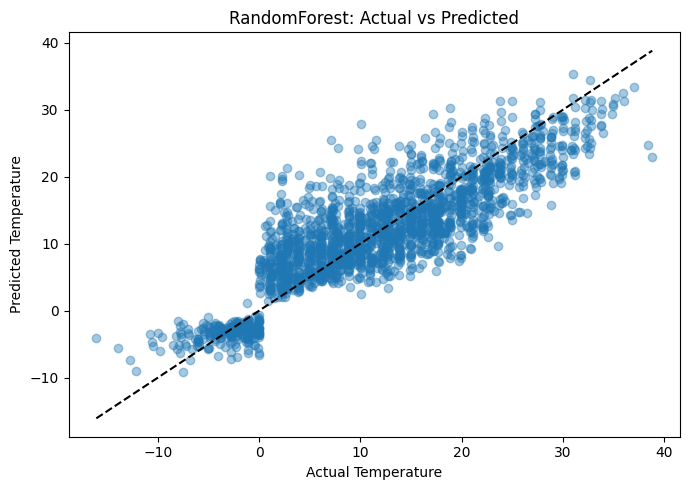

In [ ]:
# Visualisasi sederhana
# Actual vs Predicted (RF)
plt.figure(figsize=(7,5))
plt.scatter(y_test, yhat_rf, alpha=0.4)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.xlabel("Actual Temperature")
plt.ylabel("Predicted Temperature")
plt.title("RandomForest: Actual vs Predicted")
plt.tight_layout()
plt.show()

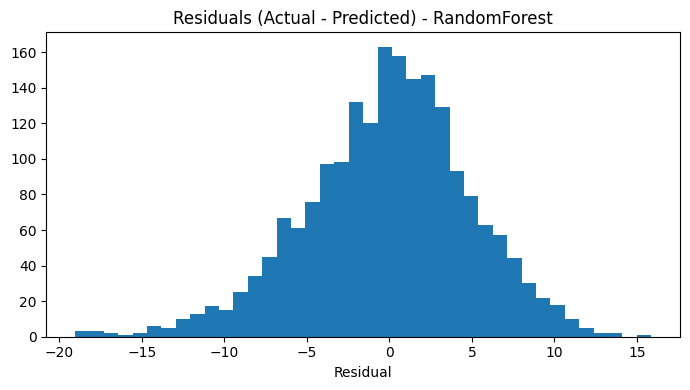

In [ ]:
# Residual histogram (RF)
res = y_test - yhat_rf
plt.figure(figsize=(7,4))
plt.hist(res, bins=40, density=False)
plt.title("Residuals (Actual - Predicted) - RandomForest")
plt.xlabel("Residual")
plt.tight_layout()
plt.show()